# Risk Groups

As we've explored the data and trained various models we know that with the data we have we can't predict each individual perfectly. But, we can rank them as risky or not risky - enough to give some indications on the most or least risky policyholders. 

In order to define the groups we will use the model that we got the performance score out of: LightGBM. 
Steps:
1. From the trained model we will predict probabilities off the test set.
2. Then we will rank the predicted risk by sorting (descending)
3. After we will define risk groups as top 10% = most risky and bottom 10% = least risky
4. Compare claim rates
5. Visualize findings

In [7]:
#import libraries 
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Trained Model and Test Set

Load the trained LightGBM model and test set that were saved in the `porto_seguro_lgbm_baseline.ipynb` notebook.

In [2]:
# Load the trained LightGBM model
lgbm_model = lgb.Booster(model_file='models/lgbm_model.txt')
print("Model loaded successfully!")

# Load the test set
with open('models/lgbm_test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

X_test = test_data['X_test']
y_test = test_data['y_test']
feature_names = test_data['feature_names']

print(f"\nTest set loaded successfully!")
print(f"Test set shape: {X_test.shape}")
print(f"Features: {len(feature_names)}")
print(f"Target distribution:\n{y_test.value_counts()}")


Model loaded successfully!

Test set loaded successfully!
Test set shape: (119043, 34)
Features: 34
Target distribution:
target
0    114704
1      4339
Name: count, dtype: int64


## 3. Predict Probabilities on Test Set

Use the trained model to predict claim probabilities for each policyholder in the test set.

We will use the values between 0 and 1, as the model indicates, with 0 being least likely and 1 being most likely to file a claim within the next 12 months.


In [4]:
# Predict probabilities
y_pred_proba = lgbm_model.predict(X_test)

print(f"Predictions generated for {len(y_pred_proba):,} policyholders")
print(f"\nProbability statistics:")
print(f"Min: {y_pred_proba.min():.4f} probability of claim")
print(f"Max: {y_pred_proba.max():.4f} probability of claim")
print(f"Mean: {y_pred_proba.mean():.4f} probability of claim")
print(f"Median: {np.median(y_pred_proba):.4f} probability of claim")


Predictions generated for 119,043 policyholders

Probability statistics:
Min: 0.0794 probability of claim
Max: 0.8344 probability of claim
Mean: 0.4643 probability of claim
Median: 0.4640 probability of claim


In [16]:
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, (y_pred_proba > 0.5).astype(int)))

AUC: 0.6378449770417823
              precision    recall  f1-score   support

           0       0.97      0.64      0.77    114704
           1       0.05      0.56      0.10      4339

    accuracy                           0.63    119043
   macro avg       0.51      0.60      0.43    119043
weighted avg       0.94      0.63      0.75    119043



Dissecting these results we can see that the model never goes to the extremes (0 or 1) and sticks between low end 0.08 and high end 0.83.

With the mean and median being around .46 we can conclude that the model is not on the same scale as real world likelihoods, it's overconfident. We know from other models and outputs we have seen previously that the real number is about 0.04. 

If we want to get a better look we would have to apply a calibration step. For another day...

- AUC: shows how well the model ranks risky vs. safe drivers.
- Precision/Recall/F1: balance between false and true claims.

In [18]:
## 4. Rank and Sort by Predicted Risk

# Create a dataframe with predictions and actual values
results_df = pd.DataFrame({
    'predicted_probability': y_pred_proba,
    'true_target': y_test.values
})

# Sort by predicted probability in descending order (highest risk first)
results_sorted = results_df.sort_values('predicted_probability', ascending=False).reset_index(drop=True)

print(f"Results sorted by predicted risk")
print(f"Total records: {len(results_sorted):,}\n")

# Take the top and bottom 10%
n = len(results_sorted)
top_10_pct = int(0.10 * n)
bottom_10_pct = int(0.10 * n)

top_10 = results_sorted.head(top_10_pct)
bottom_10 = results_sorted.tail(bottom_10_pct)

print(f"Top 10% (Most Risky): {len(top_10):,} policyholders")
print(f"Bottom 10% (Least Risky): {len(bottom_10):,} policyholders")

# Display a preview
print("\nTop 10 most risky policyholders:")
print(results_sorted.head(10))


Results sorted by predicted risk
Total records: 119,043

Top 10% (Most Risky): 11,904 policyholders
Bottom 10% (Least Risky): 11,904 policyholders

Top 10 most risky policyholders:
   predicted_probability  true_target
0               0.834411            1
1               0.830336            0
2               0.823624            0
3               0.819648            0
4               0.817978            0
5               0.817684            0
6               0.817355            1
7               0.815259            0
8               0.813910            0
9               0.813025            0


We do have a predicted risk of most and least risky:

- Most Risky 11,904 individual policyholders
- Least Risky 11,904 individual policyholders


## 5. Compare Claim Rates

Now lets take a look at claim rates by showing some performance metrics.



In [19]:
# Calculate claim rates for each risk group
top_claim_rate = top_10['true_target'].mean()
bottom_claim_rate = bottom_10['true_target'].mean()
overall_claim_rate = y_test.mean()

print("=" * 60)
print("CLAIM RATES BY RISK GROUP")
print("=" * 60)
print(f"Overall claim rate:        {overall_claim_rate:.4f} ({overall_claim_rate*100:.2f}%)")
print(f"Top 10% (Most Risky):      {top_claim_rate:.4f} ({top_claim_rate*100:.2f}%)")
print(f"Bottom 10% (Least Risky):  {bottom_claim_rate:.4f} ({bottom_claim_rate*100:.2f}%)")
print("=" * 60)
print(f"\nRisk Ratio: {top_claim_rate / bottom_claim_rate:.2f}x")
print(f"The most risky group is {top_claim_rate / bottom_claim_rate:.2f} times more likely to file a claim")


CLAIM RATES BY RISK GROUP
Overall claim rate:        0.0364 (3.64%)
Top 10% (Most Risky):      0.0796 (7.96%)
Bottom 10% (Least Risky):  0.0160 (1.60%)

Risk Ratio: 4.96x
The most risky group is 4.96 times more likely to file a claim



| Metric                           | Meaning                                                  | Interpretation                                                    |
| -------------------------------- | -------------------------------------------------------- | ----------------------------------------------------------------- |
| **Overall claim rate: 3.64%**    | Baseline rate across all 119k policyholders              | Roughly 4 in 100 people filed a claim.                            |
| **Top 10% claim rate: 7.96%**    | Claim frequency among the 11,904 highest predicted risks | About 8 in 100 — double the baseline.                             |
| **Bottom 10% claim rate: 1.60%** | Claim frequency among the safest 11,904                  | About 1.6 in 100 — less than half the baseline.                   |
| **Risk Ratio: 4.96×**            | Relative likelihood (top vs bottom decile)               | The riskiest decile is nearly **5× more likely** to file a claim. |


## 6. Visualize Risk Groups

Let's move on to some visualizations to better understand the risk distribution and model performance.

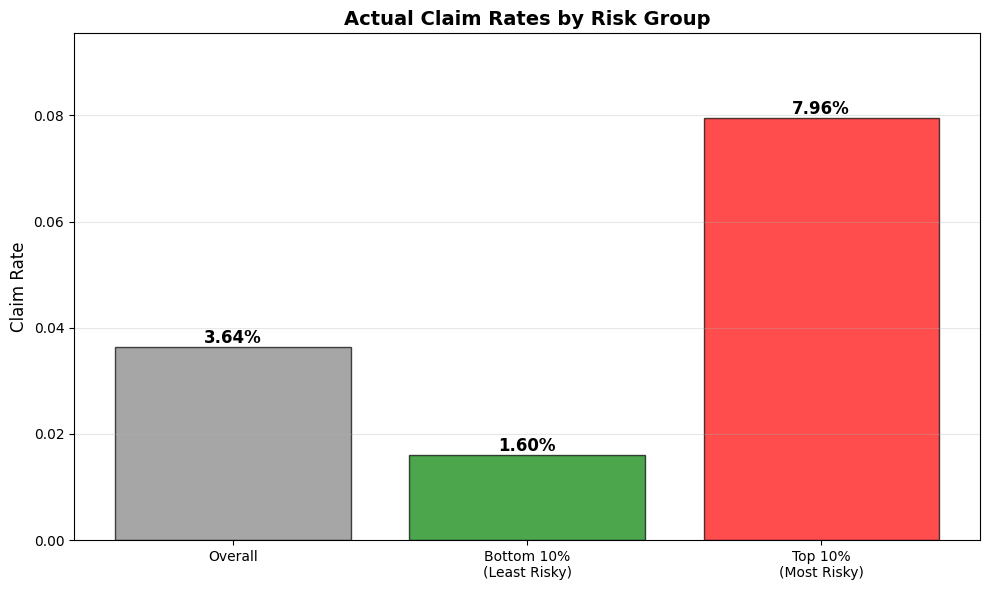

In [20]:
# Visualize claim rates by risk group
fig, ax = plt.subplots(figsize=(10, 6))

risk_groups = ['Overall', 'Bottom 10%\n(Least Risky)', 'Top 10%\n(Most Risky)']
claim_rates = [overall_claim_rate, bottom_claim_rate, top_claim_rate]
colors = ['gray', 'green', 'red']

bars = ax.bar(risk_groups, claim_rates, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height*100:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Claim Rate', fontsize=12)
ax.set_title('Actual Claim Rates by Risk Group', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(claim_rates) * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Claim Rates by Group
This visualization shows that the overall group has about a 4% likelyhood of filing a claim in the next year. The bottom 10% have a 1.6% probability and the the riskiest group has a 8% probability.

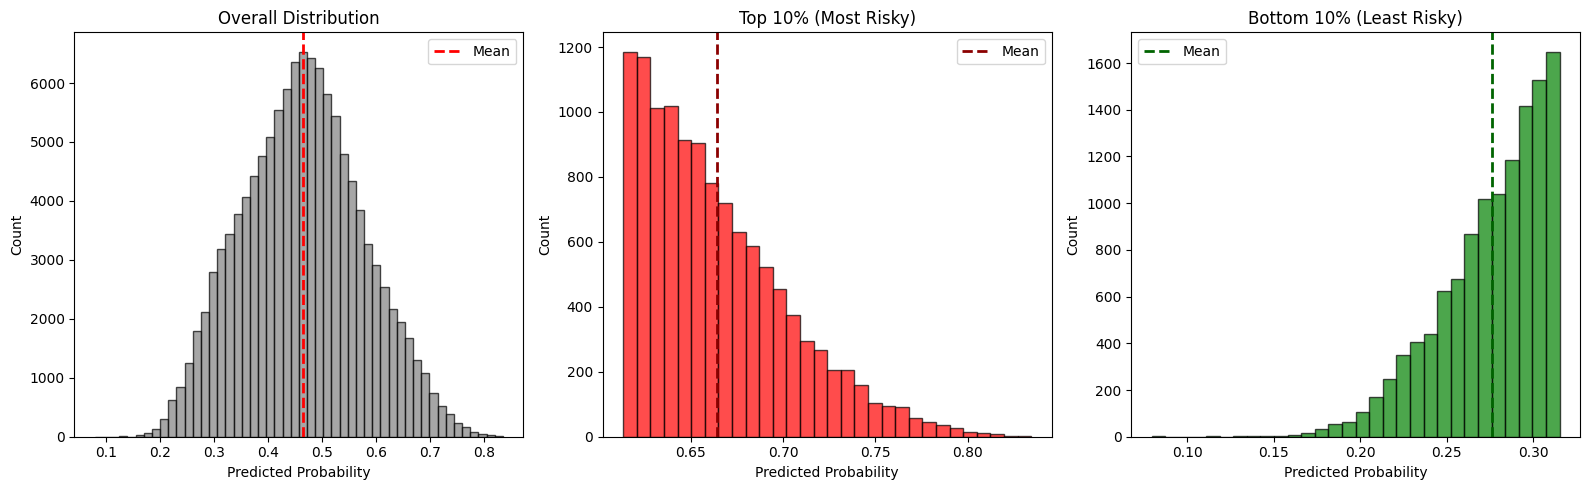

In [21]:
# Distribution of predicted probabilities
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Overall distribution
axes[0].hist(results_sorted['predicted_probability'], bins=50, color='gray', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Distribution')
axes[0].axvline(results_sorted['predicted_probability'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].legend()

# Top 10% (Most Risky)
axes[1].hist(top_10['predicted_probability'], bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Count')
axes[1].set_title('Top 10% (Most Risky)')
axes[1].axvline(top_10['predicted_probability'].mean(), color='darkred', linestyle='--', linewidth=2, label='Mean')
axes[1].legend()

# Bottom 10% (Least Risky)
axes[2].hist(bottom_10['predicted_probability'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Predicted Probability')
axes[2].set_ylabel('Count')
axes[2].set_title('Bottom 10% (Least Risky)')
axes[2].axvline(bottom_10['predicted_probability'].mean(), color='darkgreen', linestyle='--', linewidth=2, label='Mean')
axes[2].legend()

plt.tight_layout()
plt.show()


### Distribution of Probabilities

- **Overall Distribution** shows all 119,043 policy holders with the bell plotting the probability from ~0.1 → 0.85.
    - Red dotted line is the mean of 0.46.
- **Most Risky** shows the distribution of predicted probabilities for the top 10% of the individual policyholders ranked as high risk.
    - Red dotted line is the mean for this group of ~0.67
- **Least Risky** shows the distribution of predicted probabilities for the bottom 10% of individual policyholders ranked as low risk.
    - Green dotted line is the mean for the group of ~0.27


| Group              | Mean Pred. Prob. | Actual Claim Rate | Interpretation                   |
| ------------------ | ---------------- | ----------------- | -------------------------------- |
| Entire portfolio   | ≈ 0.46           | 3.6 %             | Model’s overall confidence level |
| Top 10 % (risky)   | ≈ 0.66           | 7.9 %             | High-risk concentration          |
| Bottom 10 % (safe) | ≈ 0.27           | 1.6 %             | Low-risk concentration           |


## 7. Overview and Findings

### Summary

This analysis demonstrates that while the LightGBM model cannot perfectly predict individual claim outcomes, it **successfully ranks policyholders by risk level**. By segmenting the test set into risk groups based on predicted probabilities, we can identify populations with significantly different claim rates.

### Key Findings

**1. Model Performance**
- **ROC-AUC Score**: 0.638 — indicates moderate ranking ability
- The model produces probabilities ranging from 0.08 to 0.83 (never reaching extremes)
- **Important Note**: The predicted probabilities (mean ~0.46) are not calibrated to real-world claim rates (~0.04), suggesting the model is overconfident. However, this doesn't impact the **ranking ability**.

**2. Risk Segmentation Results**

| Risk Group | Size | Actual Claim Rate | Comparison to Baseline |
|------------|------|-------------------|------------------------|
| **Overall Portfolio** | 119,043 | **3.64%** | Baseline |
| **Top 10% (Highest Risk)** | 11,904 | **7.96%** | 2.2× higher than baseline |
| **Bottom 10% (Lowest Risk)** | 11,904 | **1.60%** | 56% lower than baseline |

**3. Business Impact**
- **Risk Ratio**: The highest-risk group is **4.96× more likely** to file a claim compared to the lowest-risk group
- The model successfully separates high-risk from low-risk populations, enabling targeted actions:
  - **Premium Pricing**: Adjust premiums based on risk tier
  - **Underwriting Decisions**: Flag high-risk applicants for additional review
  - **Loss Prevention**: Focus resources on high-risk policyholders for intervention programs
  - **Portfolio Management**: Balance portfolio composition across risk levels

### Distribution Insights

The histogram analysis reveals:
- **Overall distribution**: Bell-shaped, centered around 0.46, spanning 0.1 to 0.85
- **Most Risky (Top 10%)**: Mean predicted probability ~0.67, concentrated in upper range
- **Least Risky (Bottom 10%)**: Mean predicted probability ~0.27, concentrated in lower range

Clear separation between groups validates the model's ranking capability.

### Limitations & Future Work

1. **Probability Calibration**: The predicted probabilities need calibration to match real-world claim rates. Future work could include:
   - Isotonic regression or Platt scaling
   - This would make probabilities interpretable as actual claim likelihoods

2. **Threshold Optimization**: The current analysis uses 0.5 as the decision threshold, but optimal thresholds could be determined based on:
   - Business cost-benefit analysis
   - Desired balance between false positives and false negatives

3. **Additional Segmentation**: Beyond top/bottom 10%, could create more granular risk tiers (e.g., quintiles or deciles)

### Conclusion

Despite the model's moderate AUC score and uncalibrated probabilities, it provides **actionable risk segmentation**. The nearly **5× difference in claim rates** between the highest and lowest risk groups demonstrates clear value for insurance operations. The model's primary strength lies in its ability to **rank** policyholders by risk, which is sufficient for most business applications such as pricing, underwriting, and resource allocation.